In [131]:
#Data Acquisition

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns

In [132]:
# Load the CSV file from the Resourced folder
ecom_df = pd.read_csv('Resources/ecommerce.csv')
ecom_df.head()

,REF_DATE,GEO,DGUID,Sales,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2016-01,Canada,2016A000011124,"Retail trade, unadjusted\n [44-453]",Dollars,81,thousands,3,v108795018,1.1,37415147,A,NaN,NaN,0
1,2016-01,Canada,2016A000011124,"Electronic shopping and mail-order houses, una...",Dollars,81,thousands,3,v108795019,1.2,679612,B,NaN,NaN,0
2,2016-01,Canada,2016A000011124,"Retail E-commerce sales, unadjusted\n",Dollars,81,thousands,3,v108795020,1.3,877354,A,NaN,NaN,0
3,2016-01,Canada,2016A000011124,"Retail E-commerce sales, seasonally adjusted\n",Dollars,81,thousands,3,v1257881695,1.4,977198,A,NaN,NaN,0
4,2016-02,Canada,2016A000011124,"Retail trade, unadjusted\n [44-453]",Dollars,81,thousands,3,v108795018,1.1,36815980,A,NaN,NaN,0


In [133]:
# Display basic information about the data
ecom_df.info()

# Display summary statistics
ecom_df.describe(include='all')

# Check for missing values
ecom_df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   REF_DATE       336 non-null    object 
 1   GEO            336 non-null    object 
 2   DGUID          336 non-null    object 
 3   Sales          336 non-null    object 
 4   UOM            336 non-null    object 
 5   UOM_ID         336 non-null    int64  
 6   SCALAR_FACTOR  336 non-null    object 
 7   SCALAR_ID      336 non-null    int64  
 8   VECTOR         336 non-null    object 
 9   COORDINATE     336 non-null    float64
 10  VALUE          336 non-null    int64  
 11  STATUS         336 non-null    object 
 12  SYMBOL         0 non-null      float64
 13  TERMINATED     0 non-null      float64
 14  DECIMALS       336 non-null    int64  
dtypes: float64(3), int64(4), object(8)
memory usage: 39.5+ KB


REF_DATE           0
GEO                0
DGUID              0
Sales              0
UOM                0
UOM_ID             0
SCALAR_FACTOR      0
SCALAR_ID          0
VECTOR             0
COORDINATE         0
VALUE              0
STATUS             0
SYMBOL           336
TERMINATED       336
DECIMALS           0
dtype: int64

In [134]:
# Remove columns with 100% missing values
cleaned_df = ecom_df.drop(columns=['SYMBOL', 'TERMINATED'])

# Convert REF_DATE to datetime
cleaned_df['REF_DATE'] = pd.to_datetime(cleaned_df['REF_DATE'])

# Remove columns with only one unique value
cleaned_df = cleaned_df.drop(columns=['GEO', 'DGUID', 'UOM', 'SCALAR_FACTOR', 'UOM_ID'])

# Handle duplicates
cleaned_df = cleaned_df.drop_duplicates()

# Remove newline characters from the Sales column
cleaned_df['Sales'] = cleaned_df['Sales'].str.replace('\n', '', regex=True)


# Clip outliers in the VALUE column
cleaned_df['VALUE'] = cleaned_df['VALUE'].clip(lower=ecom_df['VALUE'].quantile(0.01), upper=ecom_df['VALUE'].quantile(0.99))

# Display the cleaned data
cleaned_df.head()

,REF_DATE,Sales,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,DECIMALS
0,2016-01-01,"Retail trade, unadjusted [44-453]",3,v108795018,1.1,37415147.0,A,0
1,2016-01-01,"Electronic shopping and mail-order houses, una...",3,v108795019,1.2,679612.0,B,0
2,2016-01-01,"Retail E-commerce sales, unadjusted",3,v108795020,1.3,877354.0,A,0
3,2016-01-01,"Retail E-commerce sales, seasonally adjusted",3,v1257881695,1.4,977198.0,A,0
4,2016-02-01,"Retail trade, unadjusted [44-453]",3,v108795018,1.1,36815980.0,A,0


In [135]:
unique_dates = sorted(cleaned_df['REF_DATE'].unique())
unique_dates

num_unique_months = cleaned_df["REF_DATE"].nunique()
num_unique_months

categories = cleaned_df["Sales"].unique()

print(f"There are {num_unique_months} unique months in this data frame ")
print(f"These are the categoires in the data frame:\n  {categories} ")

There are 84 unique months in this data frame 
These are the categoires in the data frame:
  ['Retail trade, unadjusted [44-453]'
 'Electronic shopping and mail-order houses, unadjusted [45411]'
 'Retail E-commerce sales, unadjusted'
 'Retail E-commerce sales, seasonally adjusted'] 


## Seeing Data from different angles

In [136]:

# Assuming cleaned_df is your DataFrame

# Convert REF_DATE to string type
cleaned_df['REF_DATE'] = cleaned_df['REF_DATE'].astype(str)

# Extract the year from the REF_DATE column
cleaned_df['Year'] = cleaned_df['REF_DATE'].str[:4]

# Group by Sales category and Year, then sum the VALUE column
sales_by_category_year = cleaned_df.groupby(['Sales', 'Year'])['VALUE'].sum().reset_index()

# Scale the VALUE column to millions
sales_by_category_year['VALUE'] = sales_by_category_year['VALUE'] / 1_000_000

# Pivot the table to have years as columns
sales_pivot = sales_by_category_year.pivot(index='Sales', columns='Year', values='VALUE').reset_index()

# Display the pivot table
sales_pivot


Year,Sales,2016,2017,2018,2019,2020,2021,2022
0,"Electronic shopping and mail-order houses, una...",8.908062,9.875625,12.494330,16.542989,24.982113,28.587807,29.470259
1,"Retail E-commerce sales, seasonally adjusted",12.321519,15.759355,18.247294,22.485628,39.348090,46.387959,42.304637
2,"Retail E-commerce sales, unadjusted",12.321519,15.759352,18.247294,22.485630,39.348090,46.387958,42.389200
3,"Retail trade, unadjusted [44-453]",549.711319,589.173361,607.899907,616.544408,608.330374,680.101036,727.395076


The differences among the above categories 
1. "Electronic shopping and mail-order houses, unadjusted," 
2. "Retail E-commerce sales, seasonally adjusted," 
3. "Retail E-commerce sales, unadjusted,"
4. "Retail trade, unadjusted [44-453]" 

expressed in the Sales column relate to the type of retail activities they represent and whether the sales figures are seasonally adjusted or not

For this analysis we will take 3 categories: Retail E-commerce sales unadjusted, Retail E-commerce sales unadjusted, and Retail trade unadjusted [44-453]: which means that the sales figures are raw data and have not been adjusted for seasonal variations, such as increased shopping during holidays.


Please note the following distinctions for each category:

1. Electronic shopping and mail-order houses: Encompasses companies that might not have physical stores and conduct most or all of their sales online or through catalogs. i.e amazon

2. Retail E-commerce sales: Includes sales from both pure e-commerce retailers and brick-and-mortar retailers with an online presence. ie. Walmart

3. Retail trade: Unlike the other categories that focus on specific sales channels or types of businesses, "Retail trade, unadjusted [44-453]" covers the entire retail industry under the North American Industry Classification System (NAICS) codes 44-453.


In [137]:
ecom_categories = [
    "Retail E-commerce sales, unadjusted",
    "Electronic shopping and mail-order houses, unadjusted [45411]"
]

retail_category = "Retail trade, unadjusted [44-453]"

# Extract e-commerce sales data
ecom_sales = cleaned_df[cleaned_df['Sales'].isin(ecom_categories)]

# Extract retail sales data
retail_sales = cleaned_df[cleaned_df['Sales'] == retail_category]

# Summarize e-commerce sales
ecom_summary = ecom_sales.groupby(['Sales', 'Year'])['VALUE'].sum().reset_index()
ecom_summary['VALUE'] = ecom_summary['VALUE'] / 1_000_000
ecom_summary = ecom_summary.pivot(index='Year', columns='Sales', values='VALUE').reset_index()

# Summarize retail sales
retail_summary = retail_sales.groupby(['Year'])['VALUE'].sum().reset_index()
retail_summary['VALUE'] = retail_summary['VALUE'] / 1_000_000
retail_summary.rename(columns={'VALUE': 'Retail Sales (in millions)'}, inplace=True)

# Combine summaries for comparison
comparison = pd.merge(ecom_summary, retail_summary, on='Year', how='outer')

# Display the comparison table
comparison

,Year,"Electronic shopping and mail-order houses, unadjusted [45411]","Retail E-commerce sales, unadjusted",Retail Sales (in millions)
0,2016,8.908062,12.321519,549.711319
1,2017,9.875625,15.759352,589.173361
2,2018,12.494330,18.247294,607.899907
3,2019,16.542989,22.485630,616.544408
4,2020,24.982113,39.348090,608.330374
5,2021,28.587807,46.387958,680.101036
6,2022,29.470259,42.389200,727.395076


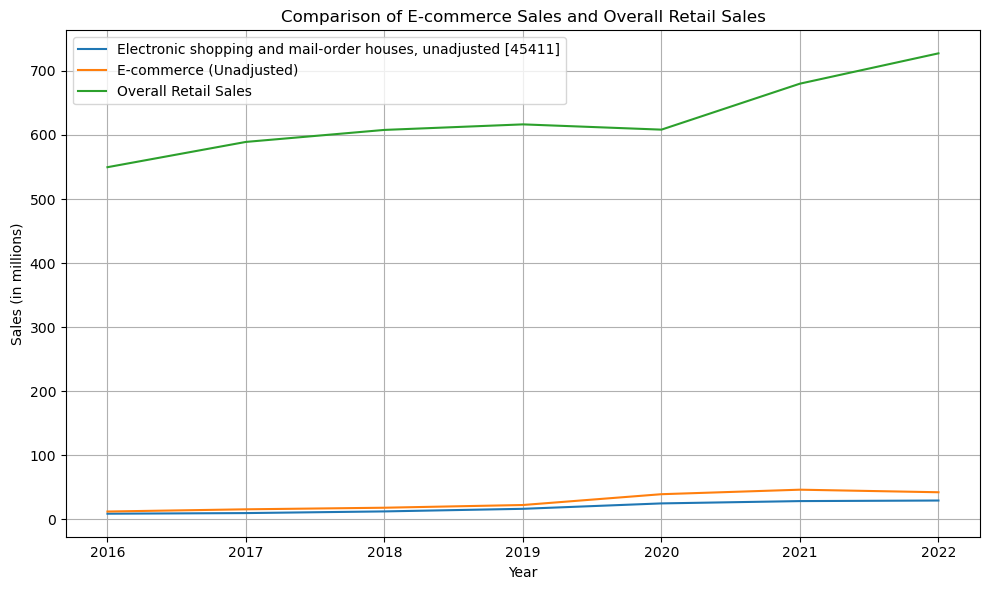

In [138]:
plt.figure(figsize=(10, 6))

# Plot the e-commerce sales
plt.plot(comparison['Year'], comparison['Electronic shopping and mail-order houses, unadjusted [45411]'], label='Electronic shopping and mail-order houses, unadjusted [45411]')
plt.plot(comparison['Year'], comparison['Retail E-commerce sales, unadjusted'], label='E-commerce (Unadjusted)')

# Plot the overall retail sales
plt.plot(comparison['Year'], comparison['Retail Sales (in millions)'], label='Overall Retail Sales')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Sales (in millions)')
plt.title('Comparison of E-commerce Sales and Overall Retail Sales')
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()


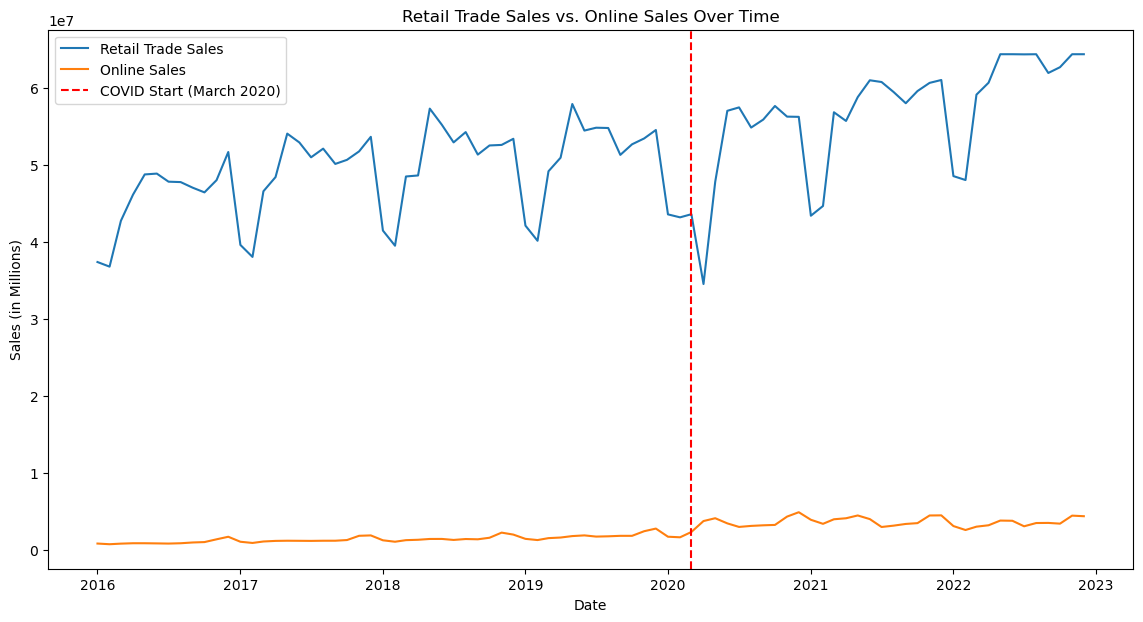

(-5.288056821151404,
 2.0194261432710503e-06,
 -18.255670755409394,
 2.6795980272813457e-25)

In [139]:
cleaned_df['REF_DATE'] = pd.to_datetime(cleaned_df['REF_DATE'])

# Define the COVID-19 impact period
covid_start = pd.to_datetime('2020-03-01')

# Split the data into pre-COVID and during-COVID periods
pre_covid = cleaned_df[cleaned_df['REF_DATE'] < covid_start]
during_covid = cleaned_df[cleaned_df['REF_DATE'] >= covid_start]

# Visualize the trends
plt.figure(figsize=(14, 7))

# Retail trade sales
retail_sales = cleaned_df[cleaned_df['Sales'].str.contains('Retail trade, unadjusted')]
plt.plot(retail_sales['REF_DATE'], retail_sales['VALUE'], label='Retail Trade Sales')

# Online sales
online_sales = cleaned_df[cleaned_df['Sales'].str.contains('Retail E-commerce sales, unadjusted')]
plt.plot(online_sales['REF_DATE'], online_sales['VALUE'], label='Online Sales')

plt.axvline(covid_start, color='red', linestyle='--', label='COVID Start (March 2020)')
plt.xlabel('Date')
plt.ylabel('Sales (in Millions)')
plt.title('Retail Trade Sales vs. Online Sales Over Time')
plt.legend()
plt.show()

# Statistical analysis
# Compare the means before and during COVID for retail sales
pre_covid_retail = pre_covid[pre_covid['Sales'].str.contains('Retail trade, unadjusted')]['VALUE']
during_covid_retail = during_covid[during_covid['Sales'].str.contains('Retail trade, unadjusted')]['VALUE']
t_stat_retail, p_val_retail = ttest_ind(pre_covid_retail, during_covid_retail, equal_var=False)

# Compare the means before and during COVID for online sales
pre_covid_online = pre_covid[pre_covid['Sales'].str.contains('Retail E-commerce sales, unadjusted')]['VALUE']
during_covid_online = during_covid[during_covid['Sales'].str.contains('Retail E-commerce sales, unadjusted')]['VALUE']
t_stat_online, p_val_online = ttest_ind(pre_covid_online, during_covid_online, equal_var=False)

t_stat_retail, p_val_retail, t_stat_online, p_val_online


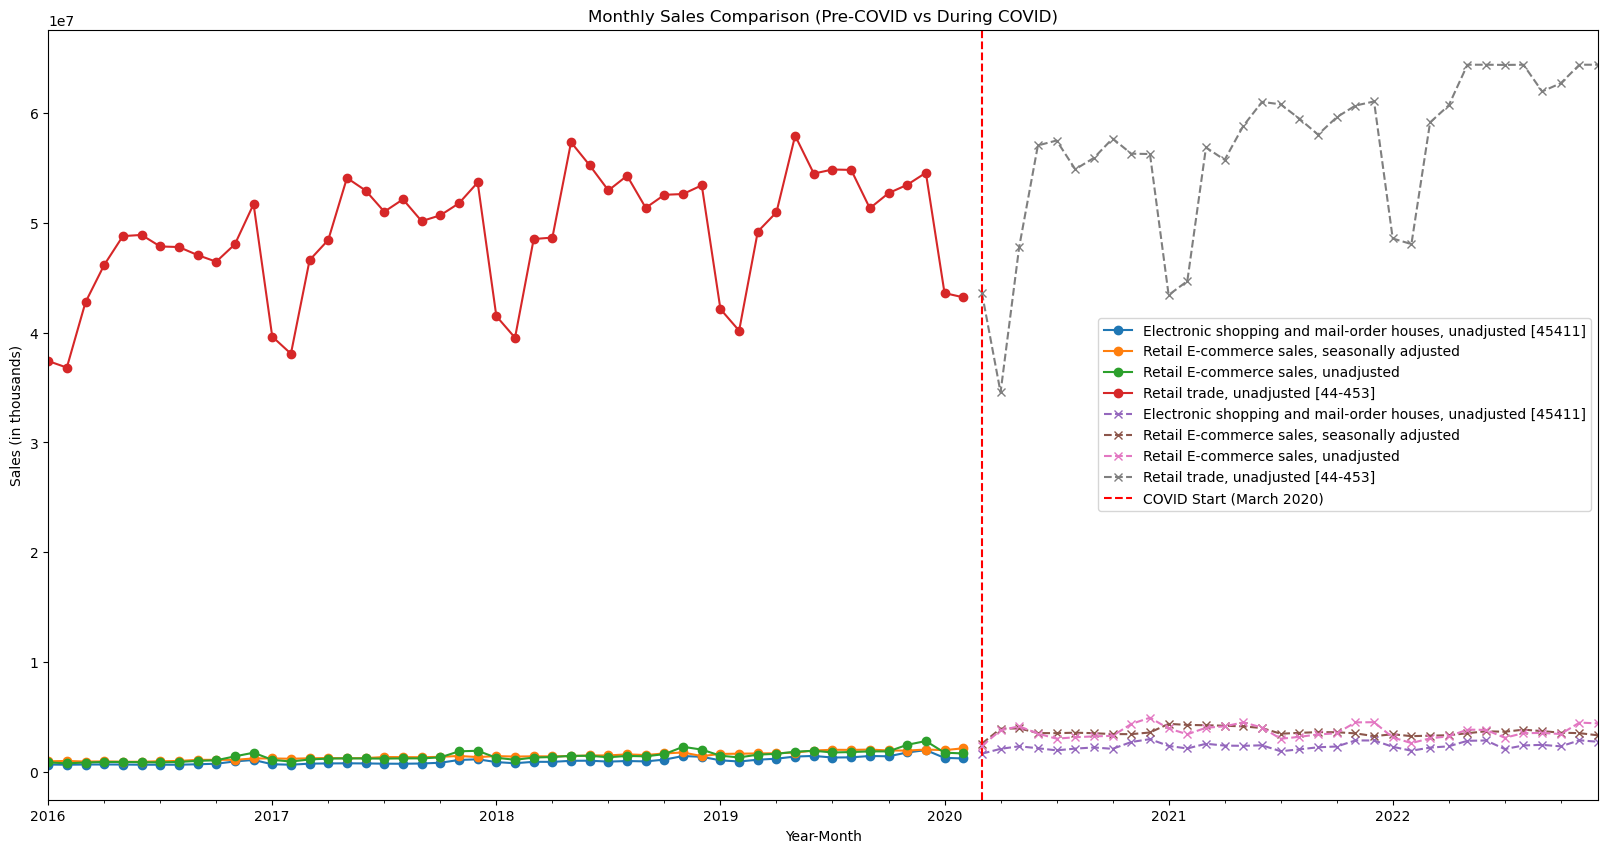

In [140]:
# Assuming cleaned_df is your DataFrame

# Convert 'REF_DATE' column to datetime if not already done
cleaned_df['REF_DATE'] = pd.to_datetime(cleaned_df['REF_DATE'])

# Group data by month and year for comparison
cleaned_df['YearMonth'] = cleaned_df['REF_DATE'].dt.to_period('M')

# Aggregate sales by month
monthly_sales = cleaned_df.groupby(['YearMonth', 'Sales'])['VALUE'].sum().unstack()

# Split the data into pre-COVID and during-COVID periods
pre_covid_monthly = monthly_sales[monthly_sales.index < '2020-03']
during_covid_monthly = monthly_sales[monthly_sales.index >= '2020-03']

# Plot monthly sales comparison
plt.figure(figsize=(20, 10))

# Pre-COVID
pre_covid_monthly.plot(ax=plt.gca(), linestyle='-', marker='o', title='Monthly Sales Comparison (Pre-COVID vs During COVID)')

# During-COVID
during_covid_monthly.plot(ax=plt.gca(), linestyle='--', marker='x')

plt.axvline(pd.to_datetime('2020-03'), color='red', linestyle='--', label='COVID Start (March 2020)')
plt.xlabel('Year-Month')
plt.ylabel('Sales (in thousands)')
plt.legend()
plt.show()


<Figure size 1400x700 with 0 Axes>

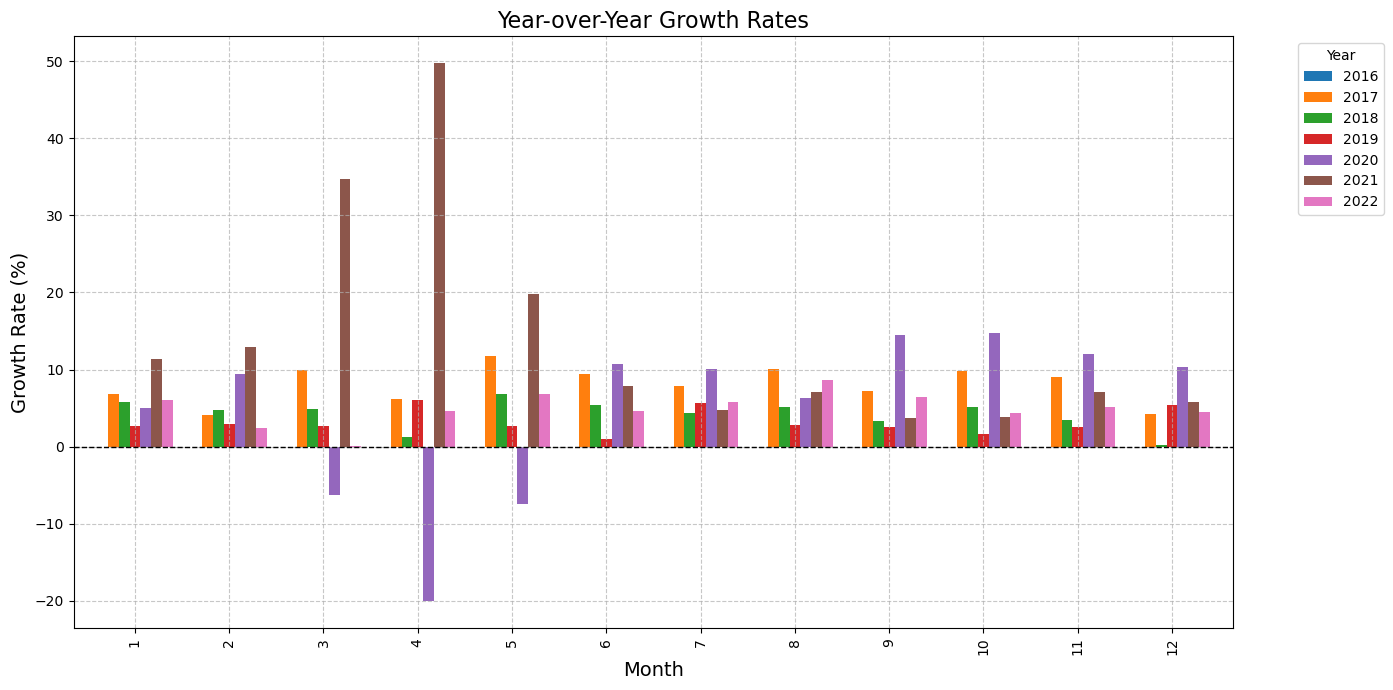

In [141]:

cleaned_df['REF_DATE'] = pd.to_datetime(cleaned_df['REF_DATE'])
# Calculate year and month
cleaned_df['Year'] = cleaned_df['REF_DATE'].dt.year
cleaned_df['Month'] = cleaned_df['REF_DATE'].dt.month
# Create pivot table for year-over-year analysis
yoy_growth = cleaned_df.pivot_table(values='VALUE', index='Month', columns='Year', aggfunc='sum')
# Calculate percentage growth year-over-year
yoy_growth = yoy_growth.pct_change(axis='columns') * 100
# Plot YoY growth rates
plt.figure(figsize=(14, 7))
ax = yoy_growth.plot(kind='bar', figsize=(14, 7), width=0.8)
# Add title and labels
ax.set_title('Year-over-Year Growth Rates', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Growth Rate (%)', fontsize=14)
# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)
# Highlight significant points (e.g., during COVID-19)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
# Improve the legend
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
# Display the plot
plt.tight_layout()
plt.show()





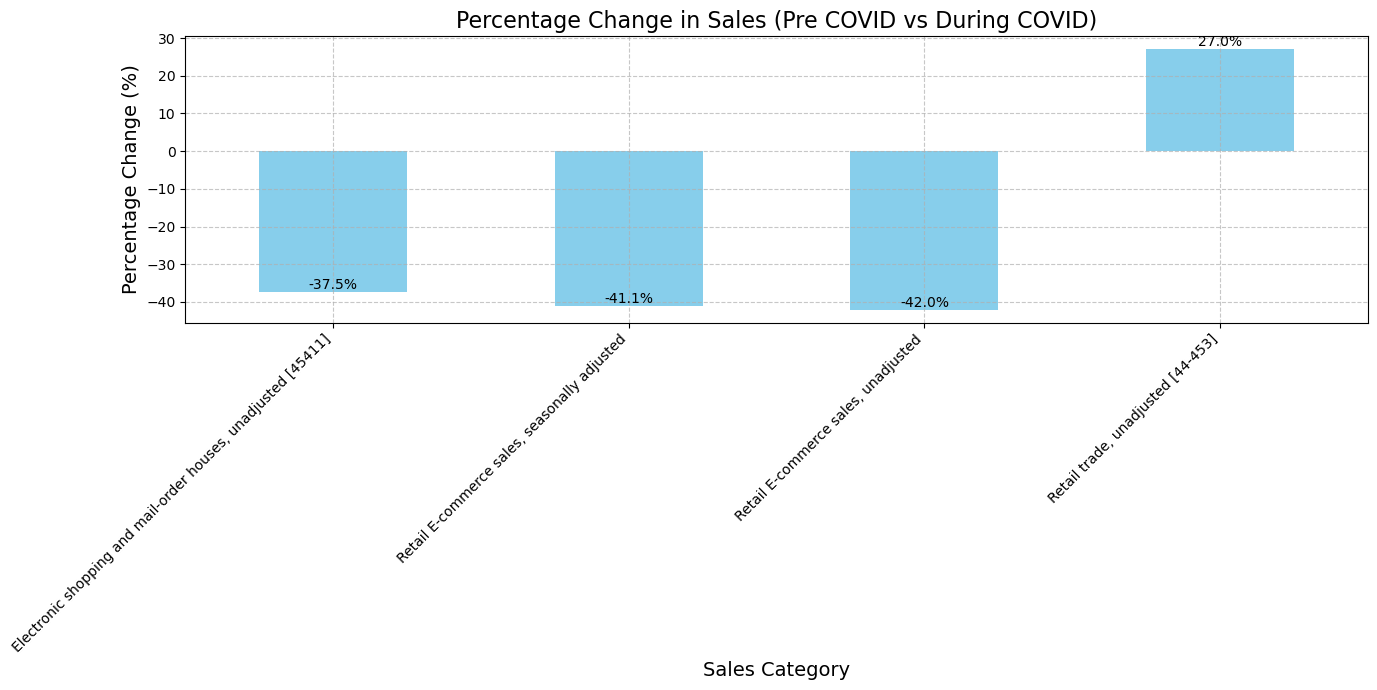

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


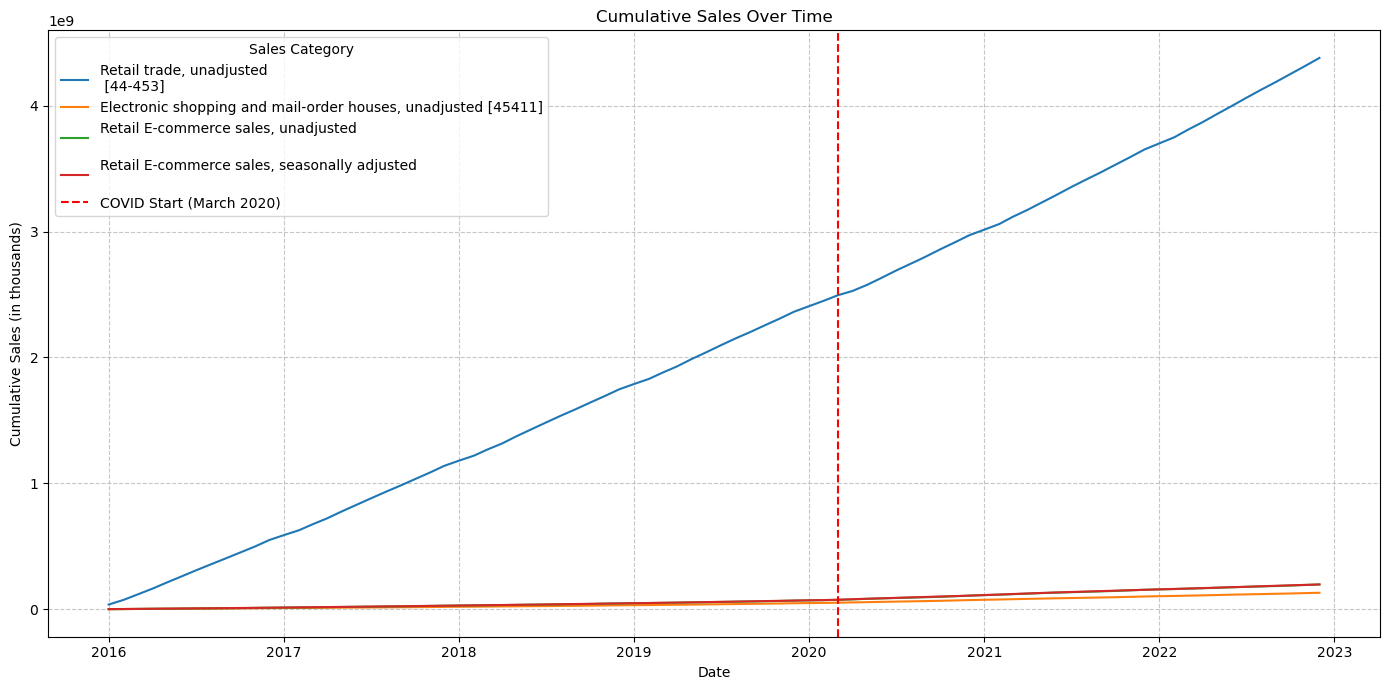

In [142]:
# Calculate percentage change in sales
cleaned_df['Period'] = cleaned_df['REF_DATE'].apply(lambda x: 'During COVID' if x >= pd.to_datetime('2020-03-01') else 'Pre COVID')
sales_change = cleaned_df.groupby(['Sales', 'Period'])['VALUE'].sum().unstack().pct_change(axis='columns').iloc[:, 1] * 100

# Plot percentage change in sales
plt.figure(figsize=(14, 7))
ax1 = sales_change.plot(kind='bar', color='skyblue', legend=False)
ax1.set_title('Percentage Change in Sales (Pre COVID vs During COVID)', fontsize=16)
ax1.set_xlabel('Sales Category', fontsize=14)
ax1.set_ylabel('Percentage Change (%)', fontsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.grid(True, linestyle='--', alpha=0.7)
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

# Calculate cumulative sales
df['Cumulative_Sales'] = cleaned_df.groupby('Sales')['VALUE'].cumsum()

# Plot cumulative sales
plt.figure(figsize=(14, 7))
sns.lineplot(x='REF_DATE', y='Cumulative_Sales', hue='Sales', data=df)
plt.axvline(pd.to_datetime('2020-03'), color='red', linestyle='--', label='COVID Start (March 2020)')
plt.title('Cumulative Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Sales (in thousands)')
plt.legend(title='Sales Category')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

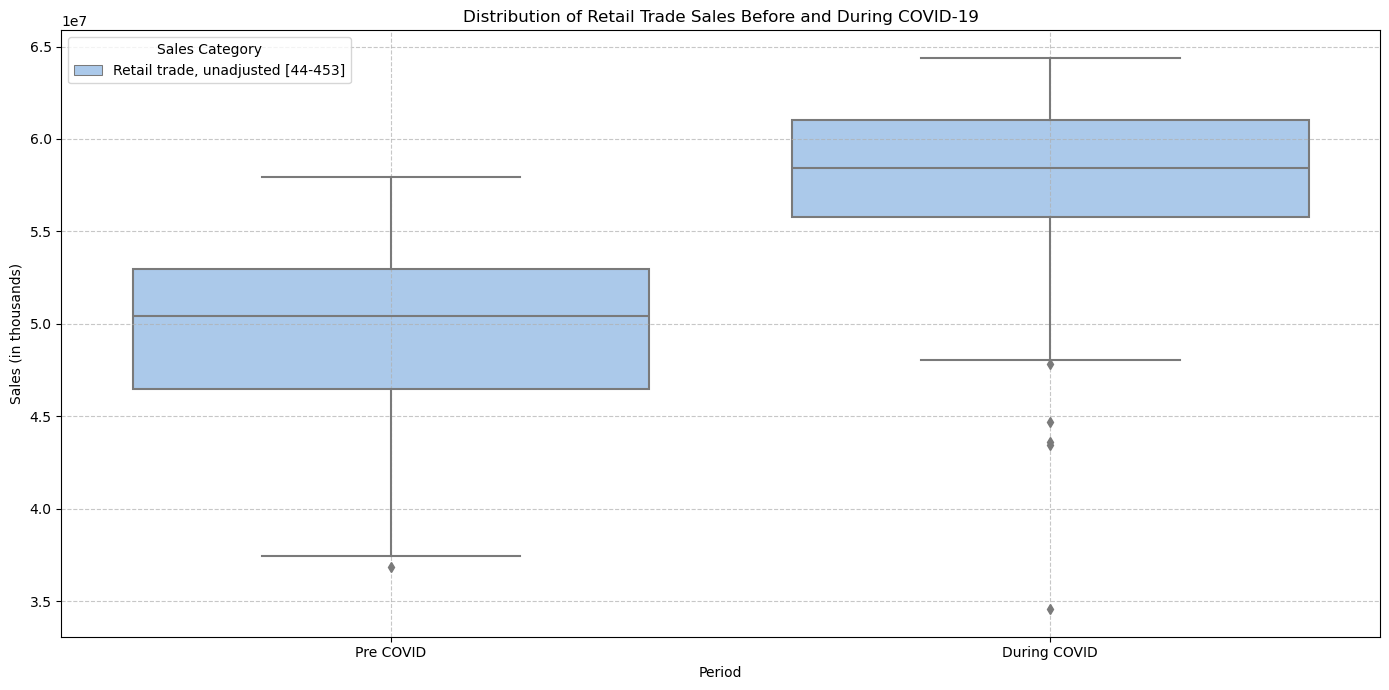

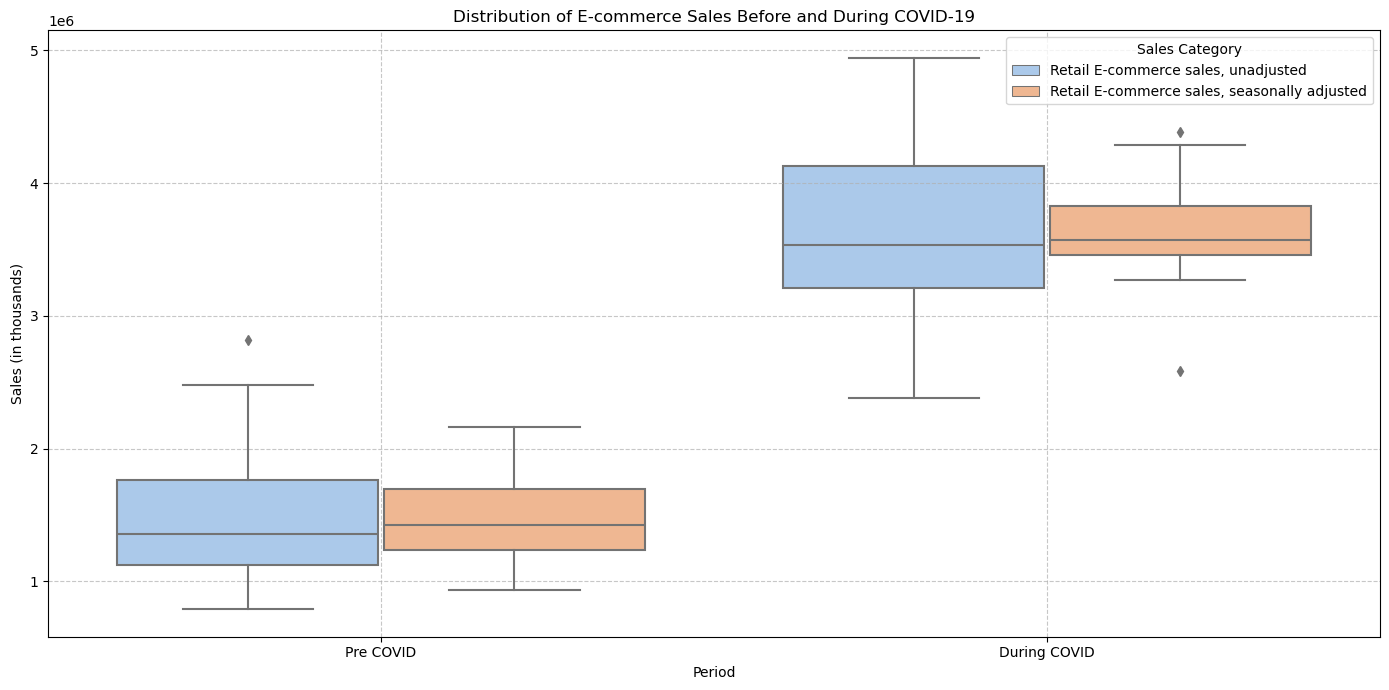

In [143]:
# Calculate the distribution of sales before and during COVID-19
cleaned_df['Period'] = cleaned_df['REF_DATE'].apply(lambda x: 'During COVID' if x >= pd.to_datetime('2020-03-01') else 'Pre COVID')

# Filter data for Retail Trade and E-commerce Sales
retail_trade = cleaned_df[cleaned_df['Sales'].str.contains('Retail trade, unadjusted')]
ecommerce_sales = cleaned_df[cleaned_df['Sales'].str.contains('E-commerce')]

# Plot distribution of sales for Retail Trade
plt.figure(figsize=(14, 7))
sns.boxplot(x='Period', y='VALUE', hue='Sales', data=retail_trade, palette='pastel')
plt.title('Distribution of Retail Trade Sales Before and During COVID-19')
plt.xlabel('Period')
plt.ylabel('Sales (in thousands)')
plt.legend(title='Sales Category')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot distribution of sales for E-commerce Sales
plt.figure(figsize=(14, 7))
sns.boxplot(x='Period', y='VALUE', hue='Sales', data=ecommerce_sales, palette='pastel')
plt.title('Distribution of E-commerce Sales Before and During COVID-19')
plt.xlabel('Period')
plt.ylabel('Sales (in thousands)')
plt.legend(title='Sales Category')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

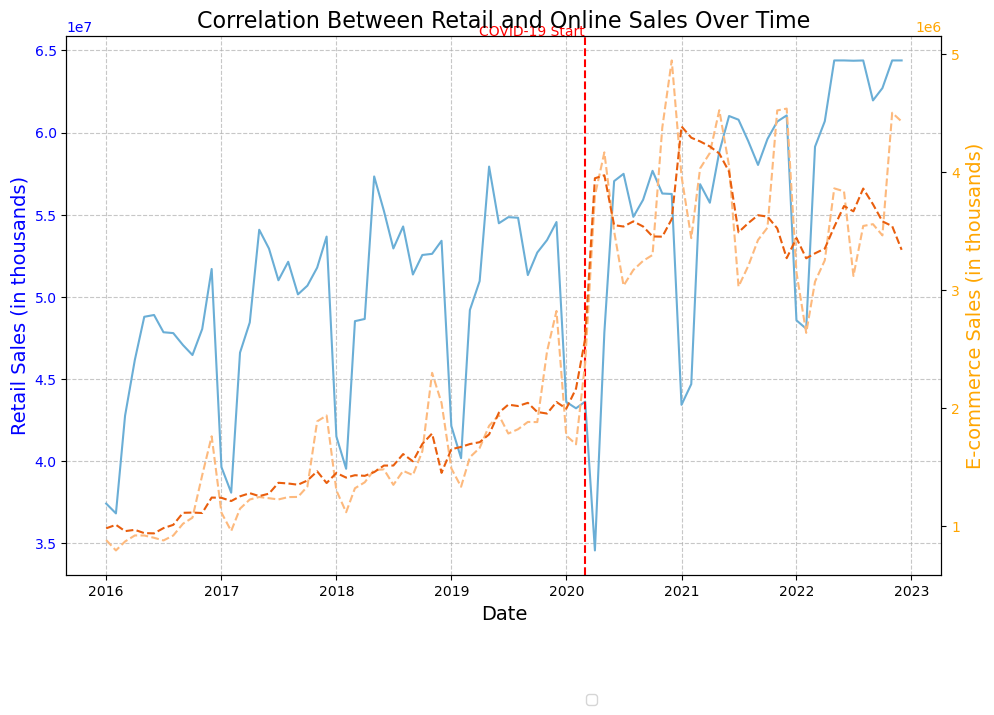

In [144]:
# Calculate cumulative sales for better trend analysis
cleaned_df['Cumulative_Sales'] = cleaned_df.groupby('Sales')['VALUE'].cumsum()

# Separate retail and e-commerce data for better visualization
retail_trade = cleaned_df[cleaned_df['Sales'].str.contains('Retail trade, unadjusted')]
ecommerce_sales = cleaned_df[cleaned_df['Sales'].str.contains('E-commerce')]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot retail trade sales on the first y-axis
sns.lineplot(x='REF_DATE', y='VALUE', hue='Sales', data=retail_trade, ax=ax1, palette='Blues', linestyle='-', legend=False)
ax1.set_title('Correlation Between Retail and Online Sales Over Time', fontsize=16)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Retail Sales (in thousands)', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a second y-axis for e-commerce sales
ax2 = ax1.twinx()
sns.lineplot(x='REF_DATE', y='VALUE', hue='Sales', data=ecommerce_sales, ax=ax2, palette='Oranges', linestyle='--', legend=False)
ax2.set_ylabel('E-commerce Sales (in thousands)', fontsize=14, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.grid(False)

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
combined_legend = handles1 + handles2
combined_labels = labels1 + labels2

# Add vertical line for COVID-19 start
ax1.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='--')
ax1.text(pd.to_datetime('2020-03-01'), ax1.get_ylim()[1], 'COVID-19 Start', color='red', ha='right')

# Adjust layout to avoid overlap
fig.subplots_adjust(right=0.75)

# Add combined legend
fig.legend(combined_legend, combined_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

# Display the plot
plt.show()

In [145]:
# Step 1: Percentage Change in Sales (Pre COVID vs During COVID)
cleaned_df['Period'] = cleaned_df['REF_DATE'].apply(lambda x: 'During COVID' if x >= pd.to_datetime('2020-03-01') else 'Pre COVID')
sales_change = cleaned_df.groupby(['Sales', 'Period'])['VALUE'].sum().unstack().pct_change(axis='columns').iloc[:, 1] * 100
sales_change = sales_change.reset_index().rename(columns={0: 'Percentage Change'})
# Step 2: Cumulative Sales Over Time
cleaned_df['Cumulative_Sales'] = cleaned_df.groupby('Sales')['VALUE'].cumsum()
cumulative_sales = cleaned_df.pivot_table(values='Cumulative_Sales', index='REF_DATE', columns='Sales')
# Step 3: Distribution of Sales Before and During COVID-19
distribution = cleaned_df.groupby(['Sales', 'Period'])['VALUE'].describe().unstack()
# Step 4: Correlation Between Retail and Online Sales Over Time
correlation_data = cleaned_df.pivot_table(values='VALUE', index='REF_DATE', columns='Sales')
correlation = correlation_data.corr()
# Display tables
print("Percentage Change in Sales (Pre COVID vs During COVID)")
display(sales_change)
print("\nCumulative Sales Over Time")
display(cumulative_sales)
print("\nDistribution of Sales Before and During COVID-19")
display(distribution)
print("\nCorrelation Between Retail and Online Sales Over Time")
display(correlation)

Percentage Change in Sales (Pre COVID vs During COVID)


,Sales,Pre COVID
0,"Electronic shopping and mail-order houses, una...",-37.472722
1,"Retail E-commerce sales, seasonally adjusted",-41.102830
2,"Retail E-commerce sales, unadjusted",-42.035030
3,"Retail trade, unadjusted [44-453]",27.015275



Cumulative Sales Over Time


Sales,"Electronic shopping and mail-order houses, unadjusted [45411]","Retail E-commerce sales, seasonally adjusted","Retail E-commerce sales, unadjusted","Retail trade, unadjusted [44-453]"
REF_DATE,,,,
2016-01-01,6.796120e+05,977198.0,877354.0,3.741515e+07
2016-02-01,1.343923e+06,1983808.0,1666907.0,7.423113e+07
2016-03-01,2.025114e+06,2936994.0,2532584.0,1.169949e+08
2016-04-01,2.711878e+06,3901273.0,3449294.0,1.631508e+08
2016-05-01,3.393070e+06,4837639.0,4365538.0,2.119342e+08
...,...,...,...,...
2022-08-01,1.204108e+08,182674497.0,180997837.0,4.125729e+09
2022-09-01,1.228836e+08,186398536.0,184553257.0,4.187681e+09
2022-10-01,1.252209e+08,189977702.0,188013556.0,4.250384e+09



Distribution of Sales Before and During COVID-19


count            \
Period                                             During COVID Pre COVID   
Sales                                                                       
Electronic shopping and mail-order houses, unad...         34.0      50.0   
Retail E-commerce sales, seasonally adjusted               34.0      50.0   
Retail E-commerce sales, unadjusted                        34.0      50.0   
Retail trade, unadjusted [44-453]                          34.0      50.0   

                                                            mean  \
Period                                              During COVID   
Sales                                                              
Electronic shopping and mail-order houses, unad...  2.368131e+06   
Retail E-commerce sales, seasonally adjusted        3.643764e+06   
Retail E-commerce sales, unadjusted                 3.666841e+06   
Retail trade, unadjusted [44-453]                   5.673569e+07   

                                                                  \
Period                                                 Pre COVID   
Sales                                                              
Electronic shopping and mail-order houses, unad...  1.006895e+06   
Retail E-commerce sales, seasonally adjusted        1.459330e+06   
Retail E-commerce sales, unadjusted                 1.445329e+06   
Retail trade, unadjusted [44-453]                   4.900284e+07   

                                                             std  \
Period                                              During COVID   
Sales                                                              
Electronic shopping and mail-order houses, unad...  3.286370e+05   
Retail E-commerce sales, seasonally adjusted        3.584242e+05   
Retail E-commerce sales, unadjusted                 6.081189e+05   
Retail trade, unadjusted [44-453]                   7.261124e+06   

                                                                          min  \
Period                                                 Pre COVID During COVID   
Sales                                                                           
Electronic shopping and mail-order houses, unad...  3.149438e+05    1667146.0   
Retail E-commerce sales, seasonally adjusted        3.493746e+05    2583398.0   
Retail E-commerce sales, unadjusted                 4.433659e+05    2379817.0   
Retail trade, unadjusted [44-453]                   5.420745e+06   34561639.0   

                                                                         25%  \
Period                                                Pre COVID During COVID   
Sales                                                                          
Electronic shopping and mail-order houses, unad...    664310.95   2133557.75   
Retail E-commerce sales, seasonally adjusted          934274.00   3460315.75   
Retail E-commerce sales, unadjusted                   789553.00   3212412.75   
Retail trade, unadjusted [44-453]                   36815980.00  55770116.00   

                                                                         50%  \
Period                                                Pre COVID During COVID   
Sales                                                                          
Electronic shopping and mail-order houses, unad...    754893.75    2338858.0   
Retail E-commerce sales, seasonally adjusted         1236259.00    3571886.5   
Retail E-commerce sales, unadjusted                  1121025.00    3533152.0   
Retail trade, unadjusted [44-453]                   46491411.25   58422277.0   

                                                                        75%  \
Period                                               Pre COVID During COVID   
Sales                                                                         
Electronic shopping and mail-order houses, unad...    952351.5   2547635.25   
Retail E-commerce sales, seasonally adjusted         1424674.0   3824077.00   
Re


Correlation Between Retail and Online Sales Over Time


Sales,"Electronic shopping and mail-order houses, unadjusted [45411]","Retail E-commerce sales, seasonally adjusted","Retail E-commerce sales, unadjusted","Retail trade, unadjusted [44-453]"
Sales,,,,
"Electronic shopping and mail-order houses, unadjusted [45411]",1.000000,0.934447,0.982364,0.649605
"Retail E-commerce sales, seasonally adjusted",0.934447,1.000000,0.940794,0.532798
"Retail E-commerce sales, unadjusted",0.982364,0.940794,1.000000,0.610681
"Retail trade, unadjusted [44-453]",0.649605,0.532798,0.610681,1.000000
